## Task 2: Set Up the Project

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 1
tf.random.set_seed(seed)

## Task 4: Load the Training Data

In [ ]:
images_directory = "/content/drive/MyDrive/Colab Notebooks/Data/flood_area_segmentation_dataset/Image"
masks_directory = "/content/drive/MyDrive/Colab Notebooks/Data/flood_area_segmentation_dataset/Mask"

In [ ]:
train_images = tf.keras.utils.image_dataset_from_directory(
    images_directory,
    labels=None,
    validation_split = 0.2,
    subset='training',
    shuffle = None,
    batch_size=32
)

train_masks = tf.keras.utils.image_dataset_from_directory(
    masks_directory,
    labels=None,
    validation_split=0.2,
    subset='training',
    shuffle=None,
    batch_size=32,
    color_mode='grayscale'
)

Found 274 files.
Using 220 files for training.
Found 274 files.
Using 220 files for training.


## Task 5: Load the Validation Data

In [ ]:
validation_images = tf.keras.utils.image_dataset_from_directory(
    images_directory,
    labels=None,
    validation_split=0.2,
    subset='validation',
    shuffle=None,
    batch_size=32
    )

validation_masks = tf.keras.utils.image_dataset_from_directory(
    masks_directory,
    labels=None,
    validation_split=0.2,
    subset='validation',
    shuffle=None,
    batch_size=32,
    color_mode='grayscale'
    )

Found 274 files.
Using 54 files for validation.
Found 274 files.
Using 54 files for validation.


## Task 6: Combine Images and Masks

In [ ]:
train_ds = tf.data.Dataset.zip((train_images,train_masks))
val_ds = tf.data.Dataset.zip((validation_images,validation_masks))

## Task 7: Visualize the Images and Masks

In [ ]:
batch = next(iter(train_ds.take(1)))
images, masks = batch[0],batch[1]

In [ ]:
sample_image, sample_mask = images[0], masks[0]

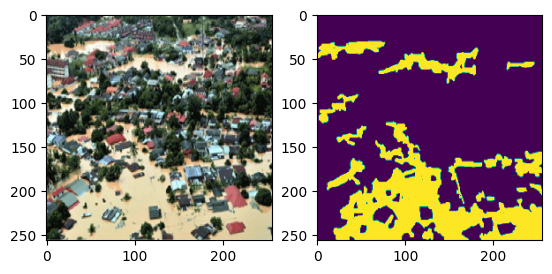

In [ ]:
plt.subplot(1,2,1)
plt.imshow((sample_image).numpy().astype(np.uint8))
plt.subplot(1,2,2)
plt.imshow((sample_mask))

## Task 8: Preprocess the Data


In [ ]:
def resize(image,mask):
    image = tf.image.resize(image,(32,32))
    mask = tf.image.resize(mask,(32,32))
    return image, mask

## Task 9: Perform Image Normalizing

In [ ]:
def normalize(image,mask):
    image = tf.cast(image,tf.float32)/255.0
    mask = tf.cast(mask,tf.float32)/255.0
    return image,mask

## Task 10: Apply Preprocessing

In [ ]:
def preprocessing(image,mask):
    image, mask = resize(image,mask)
    image, mask = normalize(image,mask)
    return image, mask

In [ ]:
batch = next(iter(train_ds.take(1)))
images, masks = batch[0], batch[1]
images.shape

TensorShape([32, 256, 256, 3])

In [ ]:
train_ds = train_ds.map(lambda x,y:(preprocessing(x,y)),num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(lambda x,y:(preprocessing(x,y)),num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
batch = next(iter(train_ds.take(1)))
images, masks = batch[0], batch[1]
images.shape

TensorShape([32, 32, 32, 3])

## Task 11: Perform Dataset Preprocessing Optimizations

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


## Task 12: Understand the U-Net Architecture
![unet](https://media.geeksforgeeks.org/wp-content/uploads/20220614121231/Group14.jpg)

## Task 13: Create the Double Convolution Block

In [ ]:
def double_conv_block(x,n_filters):
    x =tf.keras.layers.Conv2D(n_filters,3,padding='same',activation='relu',kernel_initializer='he_normal')(x)
    x =tf.keras.layers.Conv2D(n_filters,3,padding='same',activation='relu',kernel_initializer='he_normal')(x)
    return x

## Task 14: Create the Downsample Block

In [ ]:
def downsample_block(x,n_filters):
    f = double_conv_block(x,n_filters)
    p = tf.keras.layers.MaxPool2D(2)(f)
    p = tf.keras.layers.Dropout(0.3)(p)
    return f,p

## Task 15: Create the Upsample Block

In [ ]:
def upsample_block(x,conv_features, n_filters):
    x = tf.keras.layers.Conv2DTranspose(n_filters,3,2,padding='same')(x)
    x = tf.keras.layers.concatenate([x, conv_features])
    x = tf.keras.layers.Dropout(0.3)(x)
    x = double_conv_block(x,n_filters)
    return x

## Task 16: Build the U-Net Model

In [ ]:
from tensorflow.keras import layers
def build_unet_model():
    inputs = tf.keras.layers.Input(shape=(32,32,3))
    # encoder: contracting path - downsample
    f1, p1 = downsample_block(inputs, 64)   # 1 - downsample
    f2, p2 = downsample_block(p1, 128)   # 2 - downsample
    f3, p3 = downsample_block(p2, 256)   # 3 - downsample
    f4, p4 = downsample_block(p3, 512)   # 4 - downsample

    bottleneck = double_conv_block(p4, 1024)   # 5 - bottleneck

    # decoder: expanding path - upsample
    u6 = upsample_block(bottleneck, f4, 512)   # 6 - upsample
    u7 = upsample_block(u6, f3, 256)   # 7 - upsample
    u8 = upsample_block(u7, f2, 128)   # 8 - upsample
    u9 = upsample_block(u8, f1, 64)   # 9 - upsample

    # outputs
    outputs = tf.keras.layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)

    # U-Net model with Keras functional API
    unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
    return unet_model

In [ ]:
unet_model = build_unet_model()

## Task 17: Compile the Model

In [ ]:
unet_model.compile(optimizer='adam',

loss=tf.keras.losses.SparseCategoricalCrossentropy(),
          metrics=['accuracy'])

## Task 18: Train the Model

In [ ]:
unet_model.fit(
train_ds,
validation_data=val_ds,
epochs=10
)

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 130s 15s/step - accuracy: 0.4564 - loss: 0.9783 - val_accuracy: 0.6102 - val_loss: 0.6753
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 137s 15s/step - accuracy: 0.5791 - loss: 0.6611 - val_accuracy: 0.7540 - val_loss: 0.5398
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 107s 16s/step - accuracy: 0.6693 - loss: 0.5657 - val_accuracy: 0.7529 - val_loss: 0.4810
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 139s 15s/step - accuracy: 0.7204 - loss: 0.5039 - val_accuracy: 0.7750 - val_loss: 0.4281
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 102s 15s/step - accuracy: 0.7328 - loss: 0.4809 - val_accuracy: 0.7318 - val_loss: 0.5046
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 108s 16s/step - accuracy: 0.7164 - loss: 0.5169 - val_accuracy: 0.6733 - val_loss: 0.5919
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 142s 16s/step - accuracy: 0.6694 - loss: 0.5902 - val_accuracy: 0.7573 - val_loss: 0.4514
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 146s 16s/step - accuracy: 0.7249 - loss: 0.4915 - val_accuracy: 0.7641 - val_loss:

## Task 19: Make Predictions

In [ ]:
batch = next(iter(train_ds.take(1)))

images, masks = batch[0], batch[1]
predictions = unet_model.predict(images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


## Task 20: Visualize the Predictions

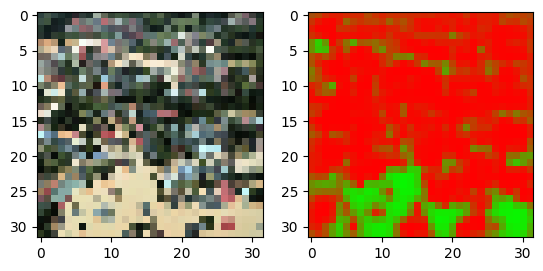

In [ ]:
plt.subplot(1, 2, 1)
plt.imshow(images[0]) # plot a sample image

plt.subplot(1, 2, 2)
plt.imshow(predictions[0]) # plot the corresponding prediction.